# Cell 0 – Environment & Imports

In [1]:
# installs (run once at top)
!pip install pandas numpy tensorflow matplotlib transformers gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.2 MB/s eta 0:00:00


In [2]:
import os, pickle, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import gradio as gr


# Cell 1 – Set Seeds & Load CSV


In [3]:
# reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# load raw CSV (just to verify)
df = pd.read_csv('/content/train.csv')
print("Loaded CSV, sample:")
df.head()

Loaded CSV, sample:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# # Cell 2 – Load Offline Tokenized Data & Build tf.data Pipelines

In [4]:
# -------------------------------------------------------------------
# 2. Model Building, Compilation, and Training with DistilBERT
# -------------------------------------------------------------------
# NOTE: Tokenization was performed offline in a separate notebook.
# The tokenized data (with keys "input_ids", "attention_masks", and "labels")
# was saved to 'tokenized_data.pkl' and then loaded and split into train/validation/test datasets.
#
# We now build and fine-tune a pre-trained, distilled transformer (DistilBERT)
# configured for multi-label classification on our toxicity dataset.

# load pre‐tokenized arrays
with open('tokenized_data.pkl','rb') as f:
    data = pickle.load(f)
input_ids, attention_masks, labels = (data[k] for k in ['input_ids','attention_masks','labels'])

# train/val/test splits
n = len(input_ids)
i_train = int(0.7*n); i_val = i_train + int(0.2*n)
splits = {
    'train': (input_ids[:i_train], attention_masks[:i_train], labels[:i_train]),
    'val':   (input_ids[i_train:i_val], attention_masks[i_train:i_val], labels[i_train:i_val]),
    'test':  (input_ids[i_val:], attention_masks[i_val:], labels[i_val:])
}

# dataset builder
def make_ds(ids, masks, labs, batch=16, buf=10000):
    ds = tf.data.Dataset.from_tensor_slices(
        ({"input_ids":ids,"attention_mask":masks}, labs)
    )
    return ds.shuffle(buf, seed=42).batch(batch).cache().prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(*splits['train'])
val_ds   = make_ds(*splits['val'])
test_ds  = make_ds(*splits['test'])

# # Cell 3 – Model Build & Initial Fine‑Tuning


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
6982/6982 [=========================

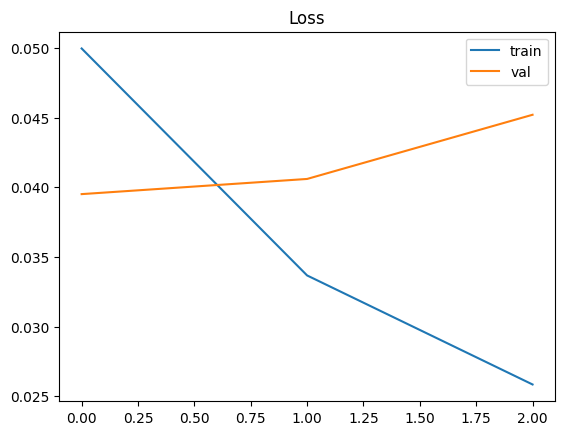

In [5]:
# Took 13m 15s to run using PAID compute (A100)
# instantiate & compile
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=6, problem_type='multi_label_classification'
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

# train
hist = model.fit(train_ds, validation_data=val_ds, epochs=3)

# plot losses
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend(); plt.title("Loss"); plt.show()


# # Cell 4 – Evaluate & Threshold‑Tune



In [6]:
#5m 14s runtime
# helper for collecting logits & labels
def collect(ds):
    logits, y = [], []
    for xb,yb in ds:
        logits.append(model(xb, training=False).logits.numpy())
        y.append(yb.numpy())
    return np.vstack(logits), np.vstack(y)

val_logits, val_true = collect(val_ds)
test_logits, test_true = collect(test_ds)

# find optimal per‑label thresholds
ths, L = [], val_true.shape[1]
for i in range(L):
    best = (0.5, 0)
    probs = 1/(1+np.exp(-val_logits[:,i]))
    for t in np.linspace(0.1,0.9,81):
        f1 = f1_score(val_true[:,i], (probs>=t).astype(int), zero_division=0)
        if f1 > best[1]: best = (t, f1)
    ths.append(best[0]); print(f"Label{i} → thresh={best[0]:.2f}, F1={best[1]:.2f}")
print("Thresholds:", ths)

# final test report
probs_test = 1/(1+np.exp(-test_logits))
preds = np.vstack([(probs_test[:,i]>=ths[i]).astype(int) for i in range(L)]).T
print(classification_report(test_true, preds,
      target_names=["toxic","severe_toxic","obscene","threat","insult","identity_hate"],
      zero_division=0))


Label0 → thresh=0.73, F1=0.82
Label1 → thresh=0.39, F1=0.56
Label2 → thresh=0.23, F1=0.83
Label3 → thresh=0.42, F1=0.52
Label4 → thresh=0.58, F1=0.76
Label5 → thresh=0.40, F1=0.62
Thresholds: [np.float64(0.73), np.float64(0.39), np.float64(0.23), np.float64(0.42000000000000004), np.float64(0.58), np.float64(0.4)]
               precision    recall  f1-score   support

        toxic       0.83      0.82      0.83      1543
 severe_toxic       0.37      0.69      0.48       150
      obscene       0.78      0.86      0.82       864
       threat       0.50      0.52      0.51        50
       insult       0.75      0.76      0.75       817
identity_hate       0.53      0.65      0.59       144

    micro avg       0.75      0.80      0.77      3568
    macro avg       0.63      0.72      0.66      3568
 weighted avg       0.77      0.80      0.78      3568
  samples avg       0.07      0.08      0.07      3568



# Cell 5 – Save Model & Tokenizer

In [7]:
out_dir = 'saved_model'
model.save_pretrained(out_dir)
DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased').save_pretrained(out_dir)
print("Saved to", out_dir)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Saved to saved_model


# Cell 6 – Scoring & Attention‑Based Explainer

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained('saved_model')
model     = TFDistilBertForSequenceClassification.from_pretrained('saved_model')

THS = ths  # reuse thresholds from above
LBL = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

def score_comment(text):
    toks  = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    probs = tf.sigmoid(model(toks).logits)[0].numpy()
    flags = (probs >= THS).astype(int)
    return "\n".join(f"{l}: {'YES' if f else 'no '} ({p:.2f})"
                     for l,f,p in zip(LBL, flags, probs))

def explain_attention(text: str, top_k: int = 10) -> str:
    # 1) Tokenize your single comment
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    # 2) Forward pass, unpacking inputs and requesting attentions
    outputs = model(
        input_ids=encoding["input_ids"],
        attention_mask=encoding["attention_mask"],
        output_attentions=True,
        training=False
    )
    attentions = outputs.attentions  # tuple of (batch, heads, seq, seq)

    # 3) Stack & average: layers → heads → batch
    #    Result shape: (seq, seq)
    attn_stack = tf.stack(attentions)                     # (L, batch, H, S, S)
    attn_mean  = tf.reduce_mean(attn_stack, axis=[1,2])   # (L, S, S)
    avg_attn   = tf.reduce_mean(attn_mean, axis=0)        # (S, S)

    # 4) Grab the [CLS] row to see how much attention it pays to each token
    cls_attn = avg_attn[0].numpy()                        # (S,)

    # 5) Map back to tokens, filter out special tokens
    toks   = encoding["input_ids"][0].numpy()
    tokens = tokenizer.convert_ids_to_tokens(toks)
    pairs  = [(tok, float(cls_attn[i]))
              for i,tok in enumerate(tokens)
              if tok not in ("[PAD]","[CLS]","[SEP]")]

    # 6) Sort and take top_k
    topk = sorted(pairs, key=lambda x: x[1], reverse=True)[:top_k]

    # 7) Format lines
    lines = [f"{tok:<12}{weight:+.4f}" for tok, weight in topk]
    return "Token       Weight\n" + "\n".join(lines)


Some layers from the model checkpoint at saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Cell 7 – Gradio Demo


In [11]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## Toxic Comment Detector 👾\n*DistilBERT + Attention explainability*")

    inp = gr.Textbox(lines=2, label="Comment")
    btn1 = gr.Button("Predict")
    btn2 = gr.Button("Explain Attention")
    out1 = gr.Textbox(label="Prediction")
    out2 = gr.Textbox(label="Top Tokens", lines=12)

    btn1.click(fn=score_comment,           inputs=inp, outputs=out1)
    btn2.click(fn=explain_attention,       inputs=inp, outputs=out2)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://776f8e0afb7eb74752.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
